# NER Accuracy


In [1]:
import json
import sys
sys.path.insert(1, '../')
from model_calls import ner_inference
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import style

/home/mattmdjaga/anaconda3/envs/rssb_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we look at the accuracy of the model compared to the graph nodes which are the ground truth.

This is done by looping over each key (title + sub title + section title) and for each 
detected entity which isn't none, we check if it in the ground truth nodes and if the ner tag is the same.
This would count as a correct detection.

This is done for test and ground truth nodes as they both give a different number.

In [2]:
nodes = json.load(open('../data/nodes.json','r'))
x = list(nodes.keys())
res = ner_inference(x, model_pth='../models/ner_model')
json.dump(res,open('ner_accuracy.json','w'))
data = pickle.load(open('../data/handbooks_parts.pt','rb'))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
c_test = 0
t_test = 0
c_true = 0
t_true = 0
for k in res.keys():
    test_ents = {x[0]:x[1] for x in res[k] if x[1] != 'None'}
    true_ents = {x[0]:x[1] for x in nodes[k] if x[1] != 'None'}
    for key in test_ents.keys():
        t_test += 1
        if key in true_ents and test_ents[key] == true_ents[key]:
            c_test += 1
    for key in true_ents.keys():
        t_true += 1
        if key in test_ents and test_ents[key] == true_ents[key]:
            c_true += 1
acc_true = ((c_true)/t_true)*100 
acc_test = ((c_test)/t_test)*100
print('Accuracy of true entities compared to test: {}%'.format(round(acc_true,2)))
print('Accuracy of test entities compared to true: {}%'.format(round(acc_test,2)))

Accuracy of true entities compared to test: 96.28%
Accuracy of test entities compared to true: 93.27%


Here we check if the ground truth entities represent the sentences in the handbooks. 

This is done by using ner to find entites for each sentence, and checking if at least 1 
entity appears in the graph entities.

In [4]:
nodes_ents = {x[0] for k, vals in nodes.items() for x in vals if x[1] != 'None'}
nodes_ents = list(nodes_ents)

In [5]:
sents = [x['sentence'] for x in data]
t = 0
c = 0
has = False
wrong = []
res = ner_inference(sents, model_pth='../models/ner_model')
for k, r in res.items():
    has = False
    test_ents = [x[0] for x in r if x[1] != 'None']
    for ent in test_ents:
        if ent in nodes_ents and not has:
           has = True
    t += 1
    if has:
        c += 1
    else:
        wrong.append((k,res[k]))
acc = round((c/t)*100,2)
print('{}% of sentences contain at least 1 graph entity'.format(acc))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


95.23% of sentences contain at least 1 graph entity


Example of a sentence without a correct entity

In [6]:
wrong[20:22]

[('When the WSMB has been replaced you must tell the PICOP.',
  [('when the', 'None'),
   ('w', 'Location'),
   ('sm', 'Object'),
   ('b', 'Action'),
   ('has been', 'None'),
   ('replaced', 'Event'),
   ('you must tell the', 'None'),
   ('pic', 'People'),
   ('op', 'Other'),
   ('.', 'None')]),
 ('The signaller will tell you when the disconnections have been made.',
  [('the', 'None'),
   ('signal', 'Object'),
   ('ler', 'Event'),
   ('will', 'None'),
   ('tell', 'Action'),
   ('you', 'People'),
   ('when the', 'None'),
   ('disconnections', 'Other'),
   ('have been', 'None'),
   ('made', 'Event'),
   ('.', 'None')])]

The next section calculates the precison, recall, and F1 score for the test nodes for each NER tag.

In [7]:
true_nodes = nodes
test_nodes = json.load(open('ner_accuracy.json','r'))

In [8]:
from collections import defaultdict
tp = defaultdict(int)
tn = defaultdict(int)
fp = defaultdict(int)
fn = defaultdict(int)

### Logic behind the next code section

test in true and class is not None:
* and tags is the same: tp
* and tags is different: fp
  
test is None:
* tn
  
test not in true and class is not None:
* fn
  

Counting the true positives, false positives, false negatives and true negatives for each NER tag

In [9]:
n = len(true_nodes)
# Count differences between clean and all_nodes
test_vals = 0
for i,k in enumerate(test_nodes.keys()):
    true_nodes_vals = [val[0] for val in true_nodes[k]]
    test_nodes_vals = [val[0] for val in test_nodes[k]]
    true_vals_tag = [val[1] for val in true_nodes[k]]
    test_nodes_vals_tag = [val[1] for val in test_nodes[k]]
    for x in test_nodes[k]:
        test_vals += 1
        val = x[0]
        tag = x[1]
        if val in true_nodes_vals:
            if tag == true_vals_tag[true_nodes_vals.index(val)]:
                if tag == 'None':
                    tn[tag] += 1
                else:
                    tp[tag] += 1
            else :
                fp[tag] += 1
        else:
            if tag == 'None':
                tn[tag] += 1
            else:
                fn[tag] += 1

Calculations and plotting

In [10]:
# Calculate precision and recall
precision = {}
recall = {}
for tag in tp:
    precision[tag] = tp[tag]/(tp[tag]+fp[tag])
    recall[tag] = tp[tag]/(tp[tag]+fn[tag])

# Calculate F1
f1 = {}
for tag in precision:
    f1[tag] = 2*precision[tag]*recall[tag]/(precision[tag]+recall[tag])

You might have to run the next cell twice if the graphs look small or axis aren't visible.

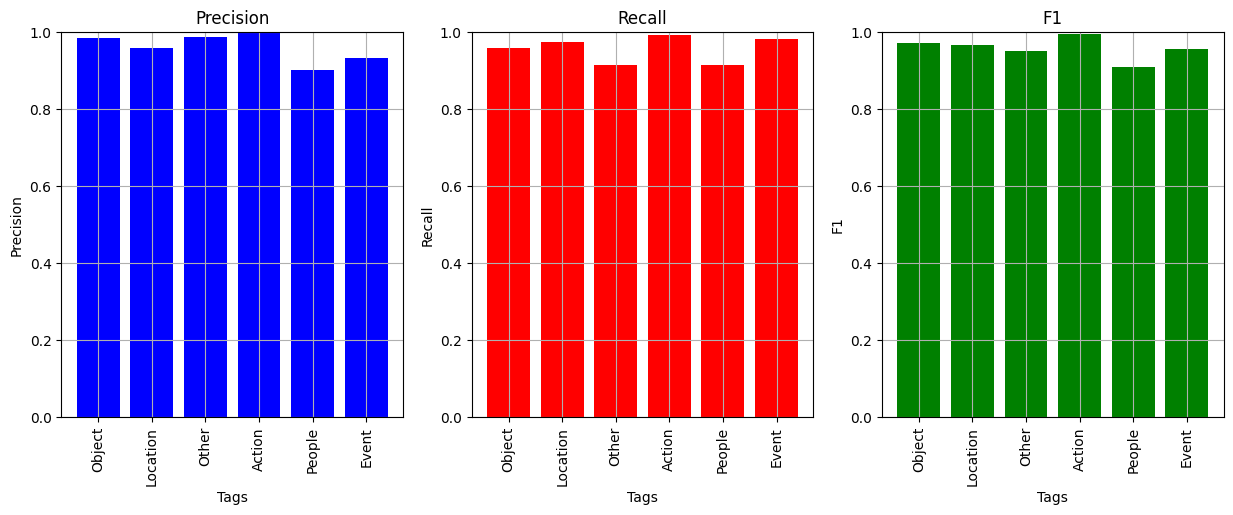

In [13]:
# Use the key and value in precision, recall and f1 to make a 3 bar plots on 1 figure

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15,5))
style.use('default')
plots = [(precision,'Precision','blue'),(recall,'Recall','red'),(f1,'F1','green')]

for (data,metric,color),ax in zip(plots,axs):
    ax.bar(list(data.keys()),list(data.values()),color=color)
    ax.set_title(metric)
    ax.set_xlabel('Tags')
    ax.set_ylabel(metric)
    ax.set_xticks(list(data.keys()))
    ax.set_xticklabels(list(data.keys()),rotation=90)
    ax.set_ylim(0,1)
    ax.grid(True)

fig.savefig('ner_accuracy.png')